In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [2]:
import FinanceDataReader as fdr

In [3]:
#빅히트(하이브)로 변경

df = fdr.DataReader('352820', '2023-06-01', '2024-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close  Volume    Change
Date                                                        
2023-06-01  274000  283000  272500  277500  273680  0.012774
2023-06-02  276000  278000  263500  270000  448545 -0.027027
2023-06-05  270000  271000  264000  265000  165535 -0.018519
2023-06-07  265000  272000  265000  269000  174858  0.015094
2023-06-08  267500  271000  265000  268000  151260 -0.003717
...            ...     ...     ...     ...     ...       ...
2024-01-18  222000  225500  217500  219500  209769 -0.017897
2024-01-19  221500  225000  217500  220000  178099  0.002278
2024-01-22  221500  222000  212500  216000  187377 -0.018182
2024-01-23  216500  224000  216500  219000  168118  0.013889
2024-01-24  220000  224000  217000  222000  107834  0.013699

[160 rows x 6 columns]>

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # 가속기 연결코드
device

device(type='cuda', index=0)

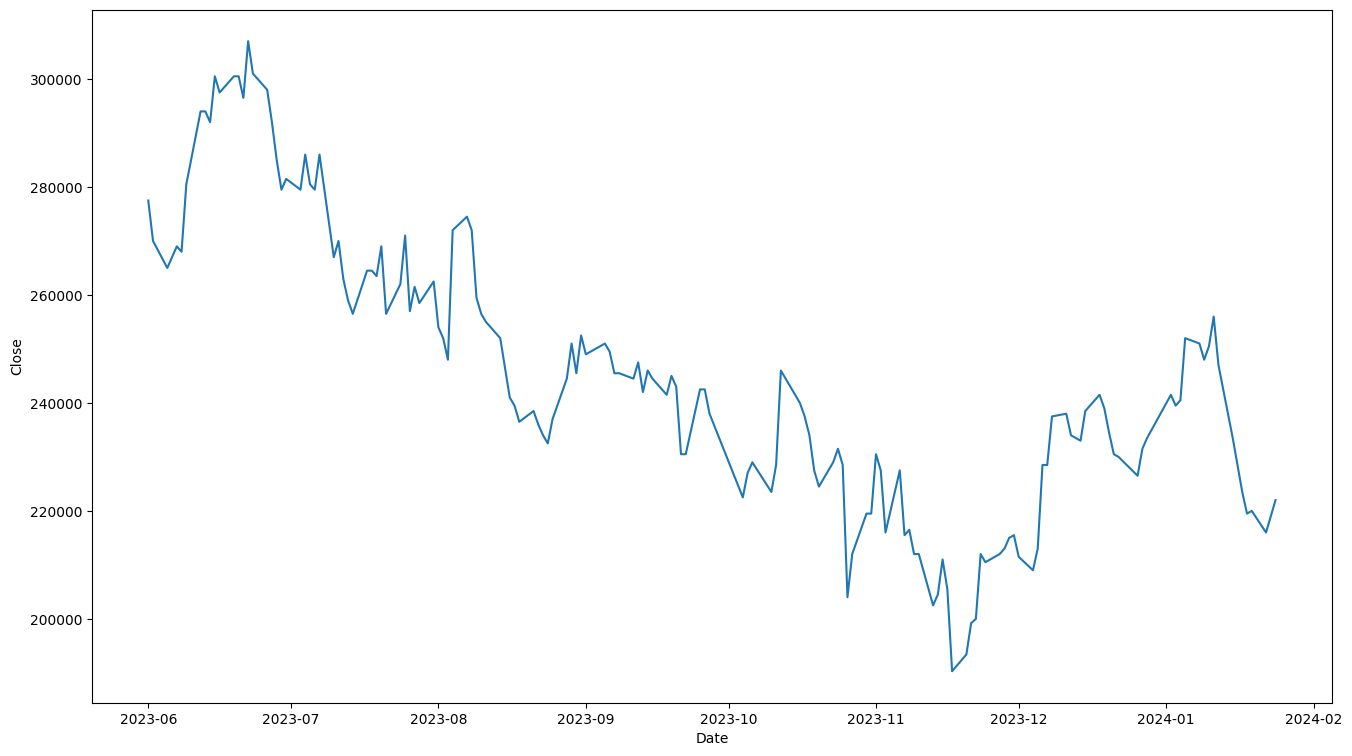

In [6]:
plt.figure(figsize=(16, 9)) # 시계열 데이터의 close 열 값을 플롯화
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

## 데이터 전처리

In [7]:
# 종가(close) 제외하고 스케일링(0-1)

scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [8]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 70
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-8-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([70, 5, 4]) torch.Size([70, 1])
torch.Size([85, 5, 4]) torch.Size([85, 1])


In [10]:
x_train_seq

tensor([[[0.7170, 0.7479, 0.7673, 0.0539],
         [0.7341, 0.7051, 0.6852, 0.1022],
         [0.6827, 0.6453, 0.6898, 0.0240],
         [0.6398, 0.6538, 0.6989, 0.0265],
         [0.6612, 0.6453, 0.6989, 0.0200]],

        [[0.7341, 0.7051, 0.6852, 0.1022],
         [0.6827, 0.6453, 0.6898, 0.0240],
         [0.6398, 0.6538, 0.6989, 0.0265],
         [0.6612, 0.6453, 0.6989, 0.0200],
         [0.6870, 0.7778, 0.7354, 0.0972]],

        [[0.6827, 0.6453, 0.6898, 0.0240],
         [0.6398, 0.6538, 0.6989, 0.0265],
         [0.6612, 0.6453, 0.6989, 0.0200],
         [0.6870, 0.7778, 0.7354, 0.0972],
         [0.8070, 0.8504, 0.8449, 0.0895]],

        ...,

        [[0.5197, 0.4872, 0.5347, 0.0000],
         [0.4854, 0.4829, 0.4982, 0.0143],
         [0.4726, 0.4487, 0.4799, 0.0157],
         [0.4640, 0.4316, 0.4571, 0.0127],
         [0.4683, 0.4915, 0.4891, 0.0237]],

        [[0.4854, 0.4829, 0.4982, 0.0143],
         [0.4726, 0.4487, 0.4799, 0.0157],
         [0.4640, 0.4316, 0.4571

In [11]:
#학습 및 테스트 데이터 로드

train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

## Vanila RNN

In [12]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [13]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())
    #RNN 층에서 나온 결과를 fc(fully connected) 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0) # RNN 층을 통과한 결과 반환
    out = out.reshape(out.shape[0], -1) # 펼친 형태로 반환
    out = self.fc(out) # fc 층 최종 출력계산
    return out

In [14]:
model = VanillaRNN(input_size=input_size, # 모델지정
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [15]:
criterion = nn.MSELoss() # 하이퍼 파라미터 지정
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습


In [16]:
loss_graph = [] # 손실 기록
n = len(train_loader) # 배치 수

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader: # 배치에 대해 반복
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad() # 기울기 초기화
    loss.backward() # 역전파
    optimizer.step() #최적화
    running_loss += loss.item() # 배치의 손실을 누적

  loss_graph.append(running_loss/n) # 평균 손실값 리스트 추가
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0422
[epoch : 10] loss: 0.0104
[epoch : 20] loss: 0.0089
[epoch : 30] loss: 0.0077
[epoch : 40] loss: 0.0072


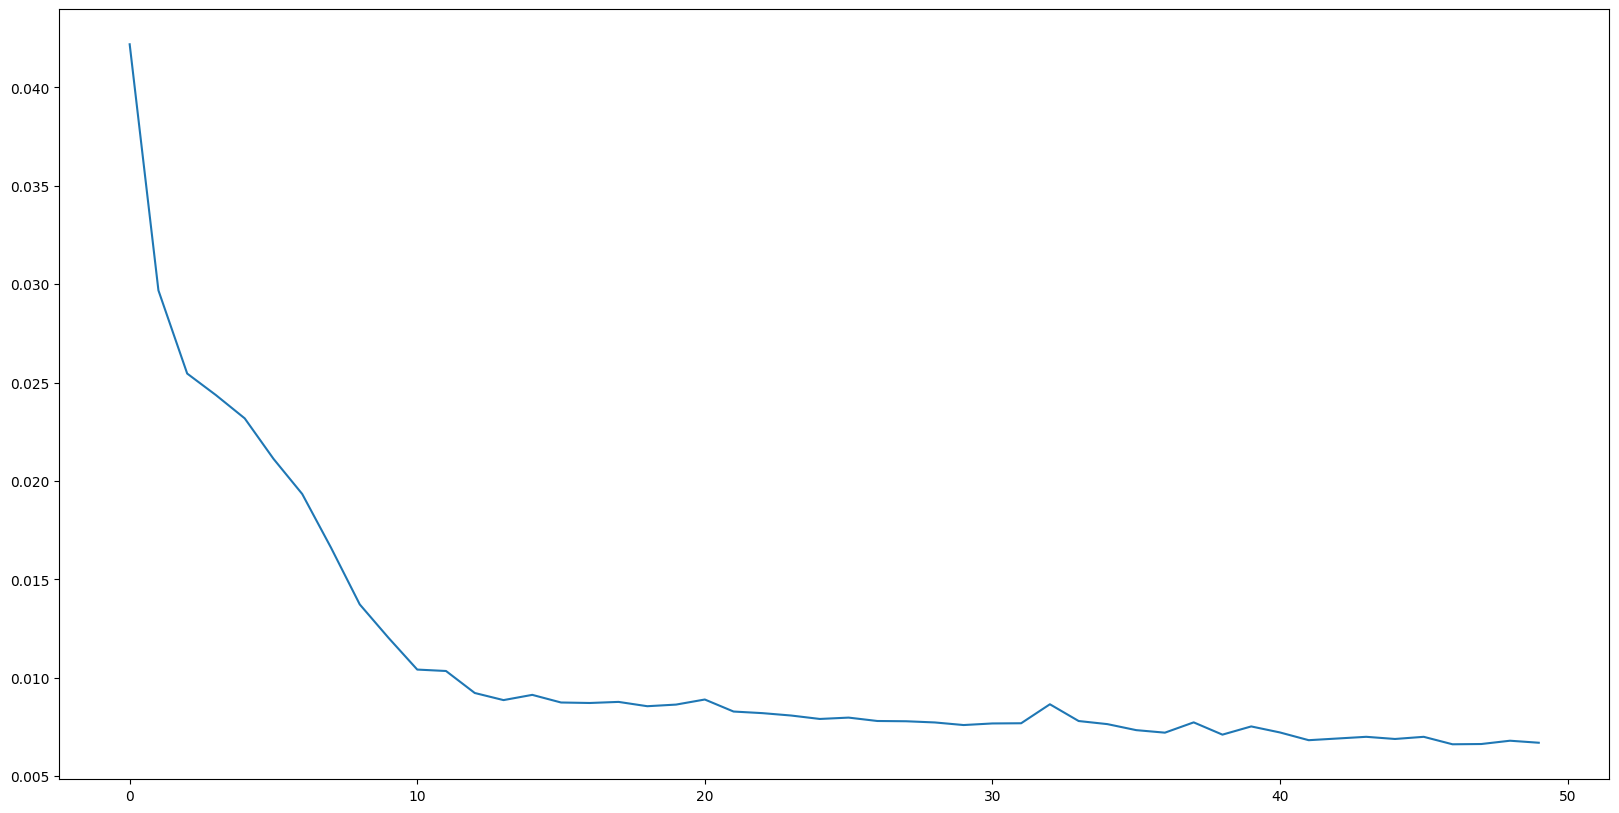

In [17]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [18]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()  # 모델을 평가 모드로 설정
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()


In [19]:
pred[:10]

[[0.6858291625976562],
 [0.6881632208824158],
 [0.7233338356018066],
 [0.7761412262916565],
 [0.8183901906013489],
 [0.8425400257110596],
 [0.8555840253829956],
 [0.8622519969940186],
 [0.8656831383705139],
 [0.8659632802009583]]

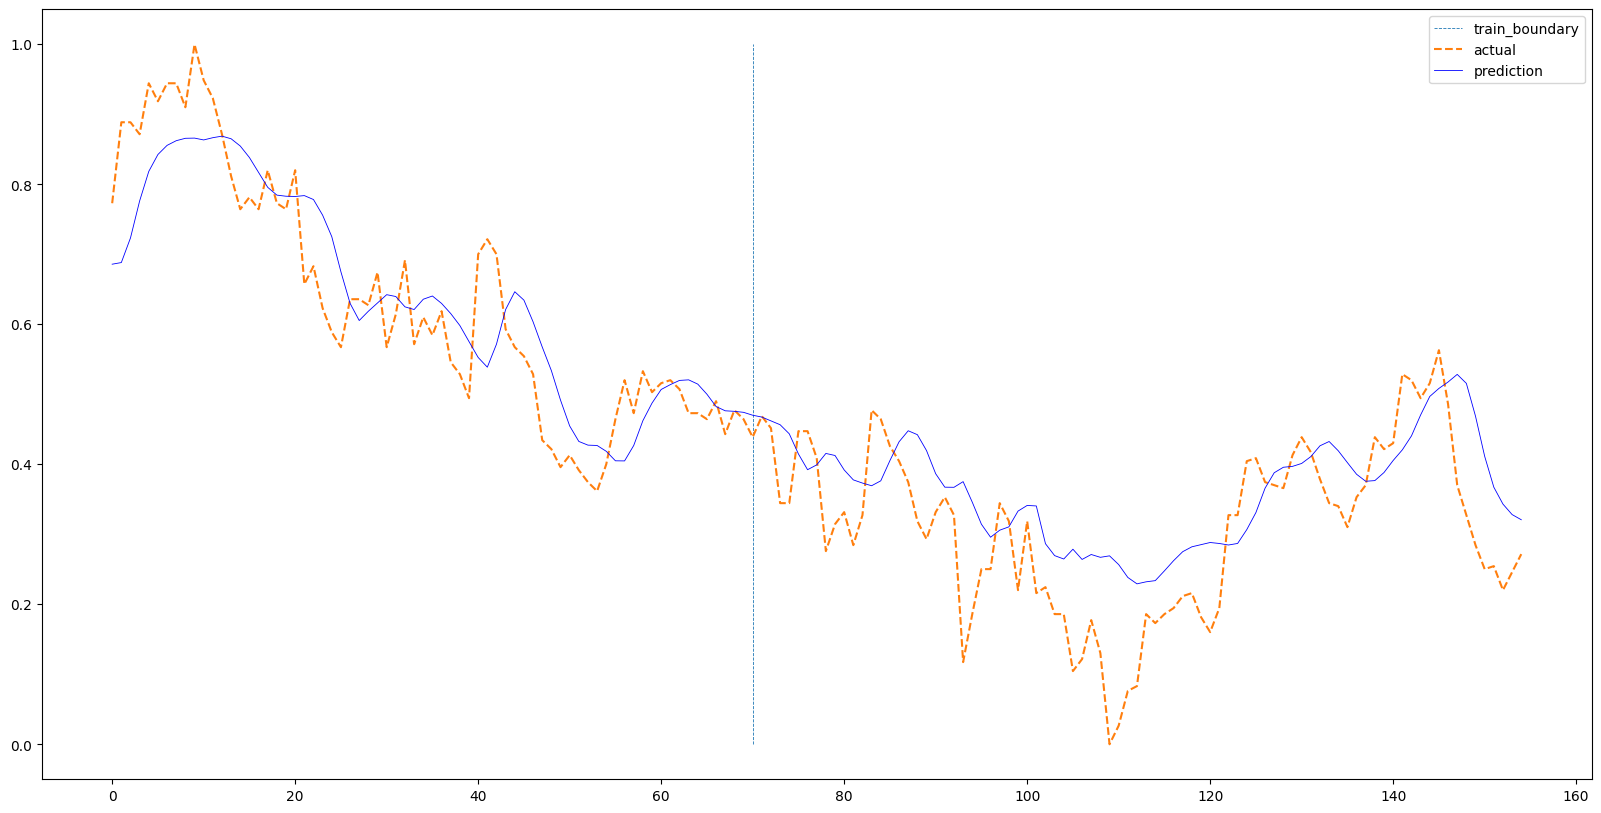

In [20]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6) # 학습데이터 끝 부분
plt.plot(df['Close'][sequence_length:].values,'--') # 실제 종가 데이터
plt.plot(pred, 'b', linewidth = 0.6) # 예측 결과
plt.legend(['train_boundary','actual','prediction'])
plt.show()

## LSTM

In [21]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [22]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    # RNN 과 다르게 은닉상태, 셀 상태를 다 초기화
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [23]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [24]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.2669
[epoch: 10] loss: 0.0255
[epoch: 20] loss: 0.0166
[epoch: 30] loss: 0.0090
[epoch: 40] loss: 0.0088


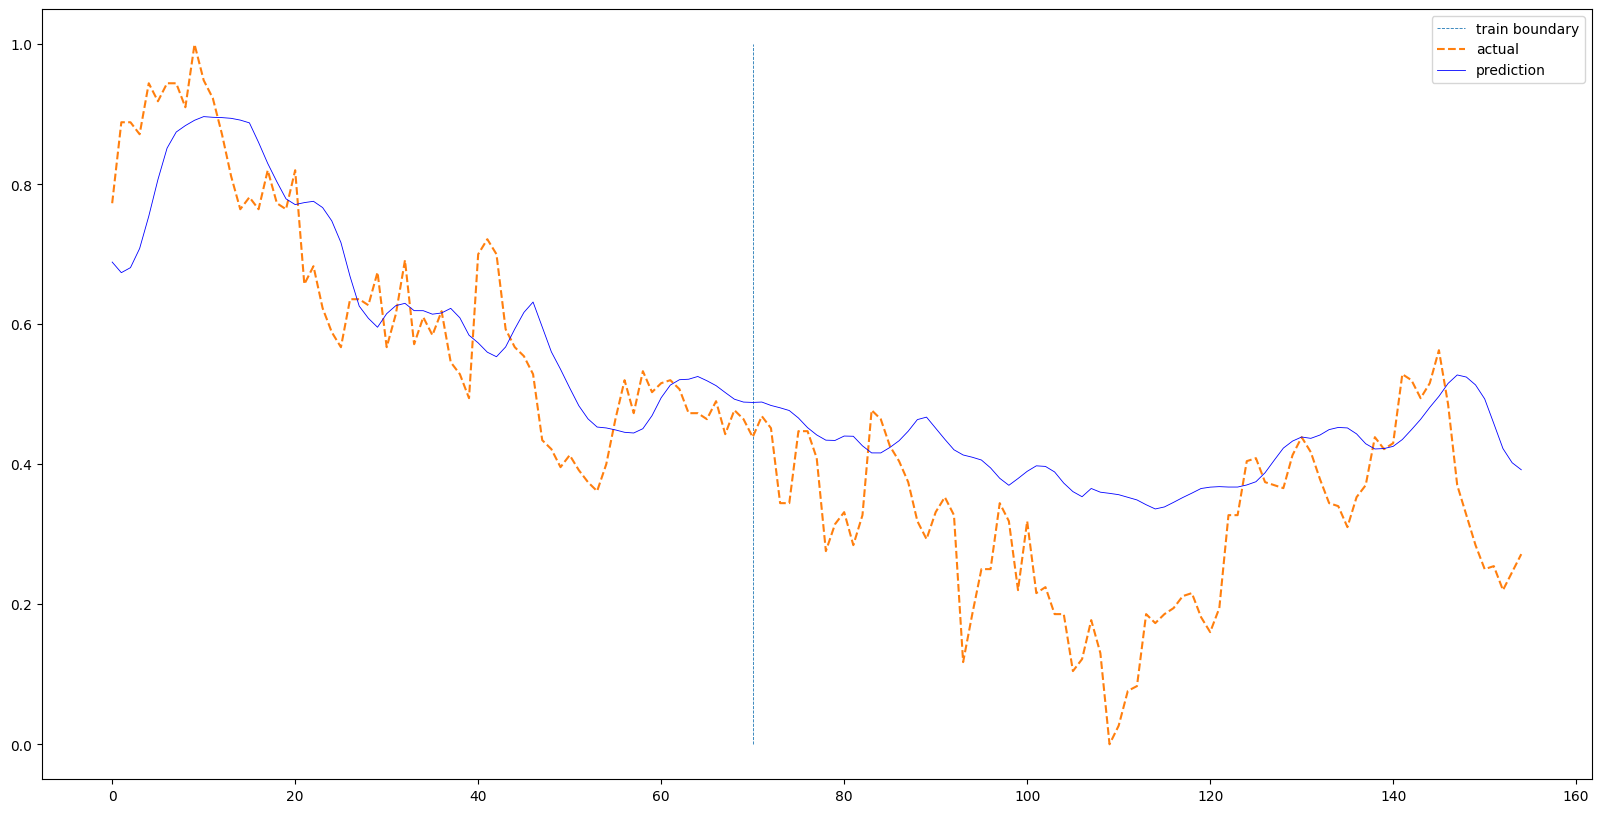

In [26]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()